In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'deeplearning:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4781919%2F8098248%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240531%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240531T223332Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1d9df1932e4f1524a93b8f06836b3381a38a264f956922c9336c94531b9f4b0945569cf1fa0bd9d9adb527c39a428a5c73264ba735d3eced1442182e85acb2e6bbad67ea314ad83f2cb88b870a3f896c217b544d8b6d56e0ec2aba4b6e71a141e92bf206ce418d818c80bd24721dd047d42b91560e7580f77b7455d8cbf82a1fe85e4d161da385c6186850b5eddd7f245b0cfb1822c2940ae92d93c056aecf1b324f9e9b5ac7f251dc3c38561963101808c751105b95c02d5c6457a25969c61bc6c97c5b1db5d95e7d6143af8a79c8da9fb4e5518c730ab0f1dff55c3b0dae73f3afd4e5400c6cde63851e249cb150cc22b6ca22444d5ad4118d23ada8962c9b'
KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'


!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3393467440 bytes downloaded
Downloaded and uncompressed: deeplearning
Data source import complete.


In [ ]:
pip install imagehash


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 5.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import imagehash
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.applications import VGG16
from keras.applications import ResNet101
from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam

In [ ]:
train_path = '/kaggle/input/deeplearning/Data Main/train'
test_path = '/kaggle/input/deeplearning/Data Main/test'


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
size_images = 150
batch_size = 32

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode ='categorical'
)

Found 31571 images belonging to 4 classes.


In [ ]:
labels_count = train_generator.classes

In [ ]:
print(labels_count)


[0 0 0 ... 3 3 3]


<ipython-input-15-5cb8d2510efe>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names, rotation=45, ha='right')


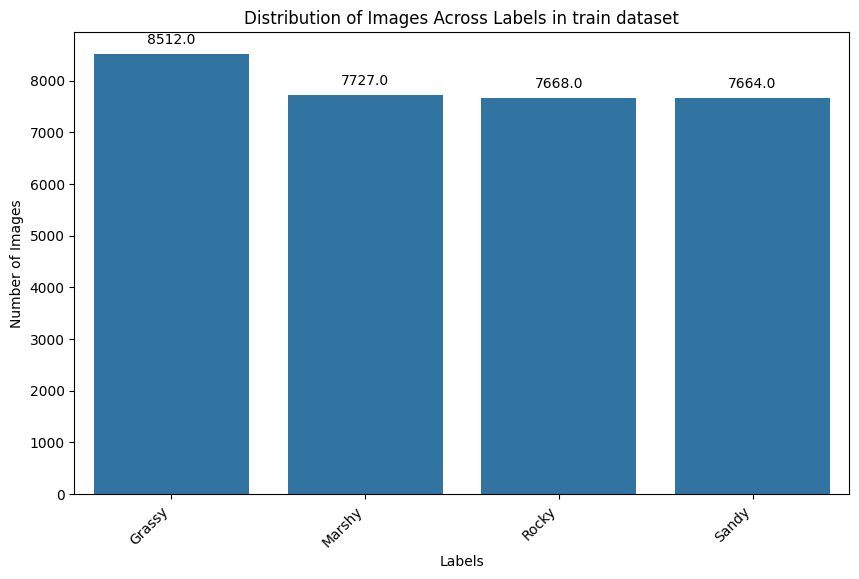

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
labels_count = train_generator.classes
class_names = list(train_generator.class_indices.keys())
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=labels_count)
plt.title('Distribution of Images Across Labels in train dataset')
plt.xlabel('Labels')
plt.ylabel('Number of Images')
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.set_xticklabels(class_names, rotation=45, ha='right')
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

Found 6769 images belonging to 4 classes.


<ipython-input-18-15f5aa0577ff>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names, rotation=45, ha='right')


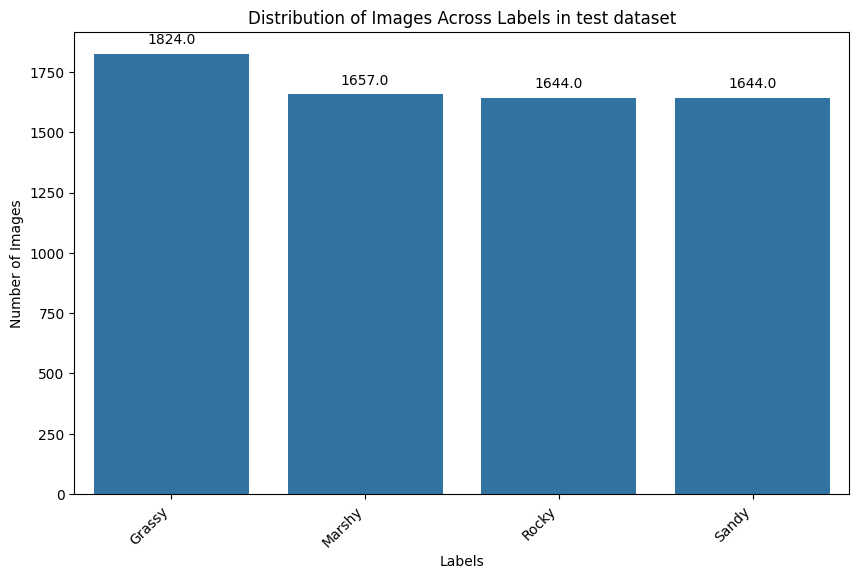

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
labels_count = test_generator.classes
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=labels_count)
plt.title('Distribution of Images Across Labels in test dataset')
plt.xlabel('Labels')
plt.ylabel('Number of Images')
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.set_xticklabels(class_names, rotation=45, ha='right')
plt.show()

In [ ]:
def Show_Images(target_gen):
    batch_images, batch_labels = next(target_gen)
    class_labels = list(target_gen.class_indices.keys())
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])
        plt.axis('off')
    plt.show()

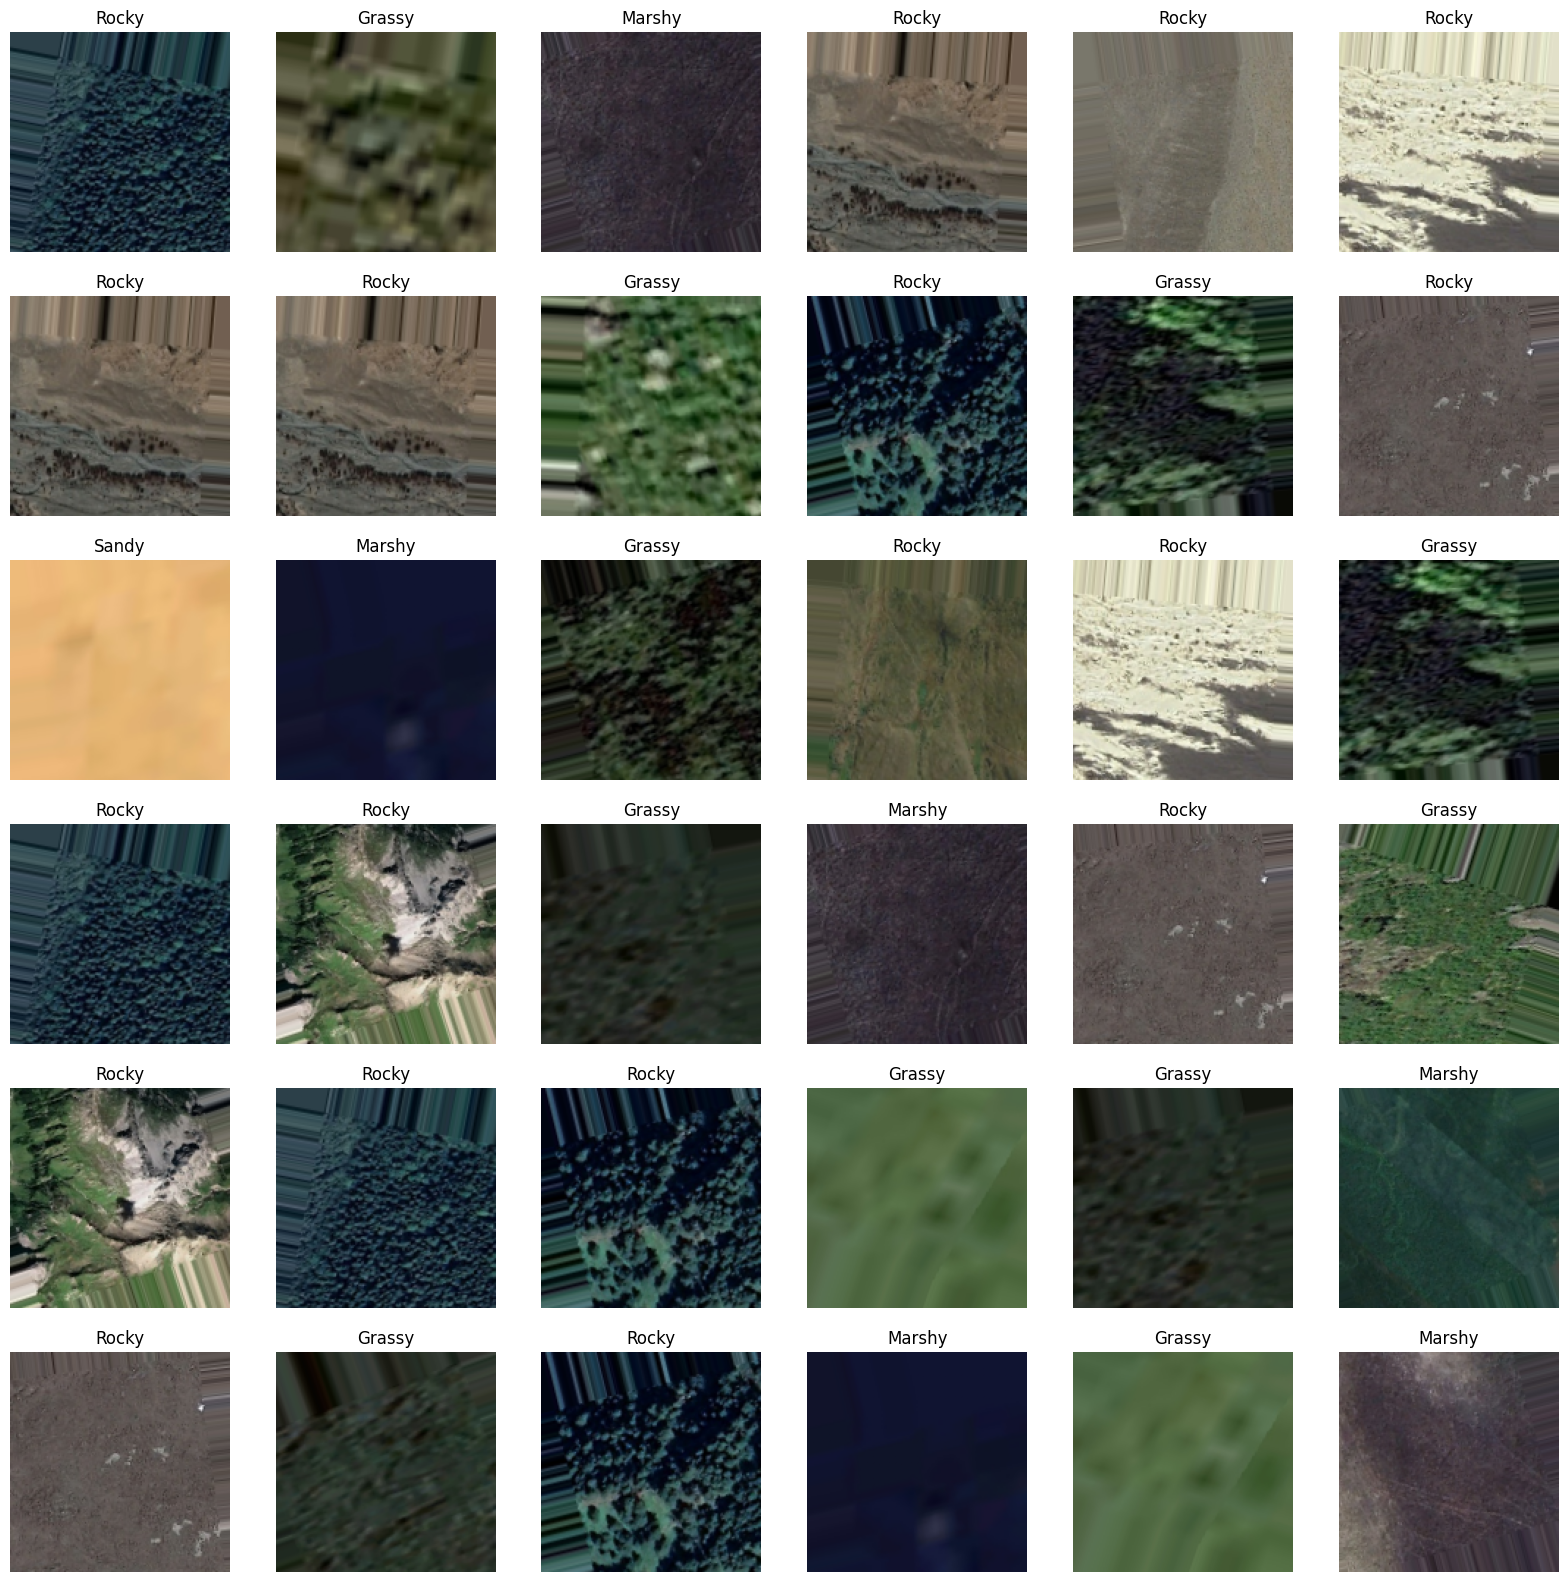

In [ ]:
Show_Images(train_generator)

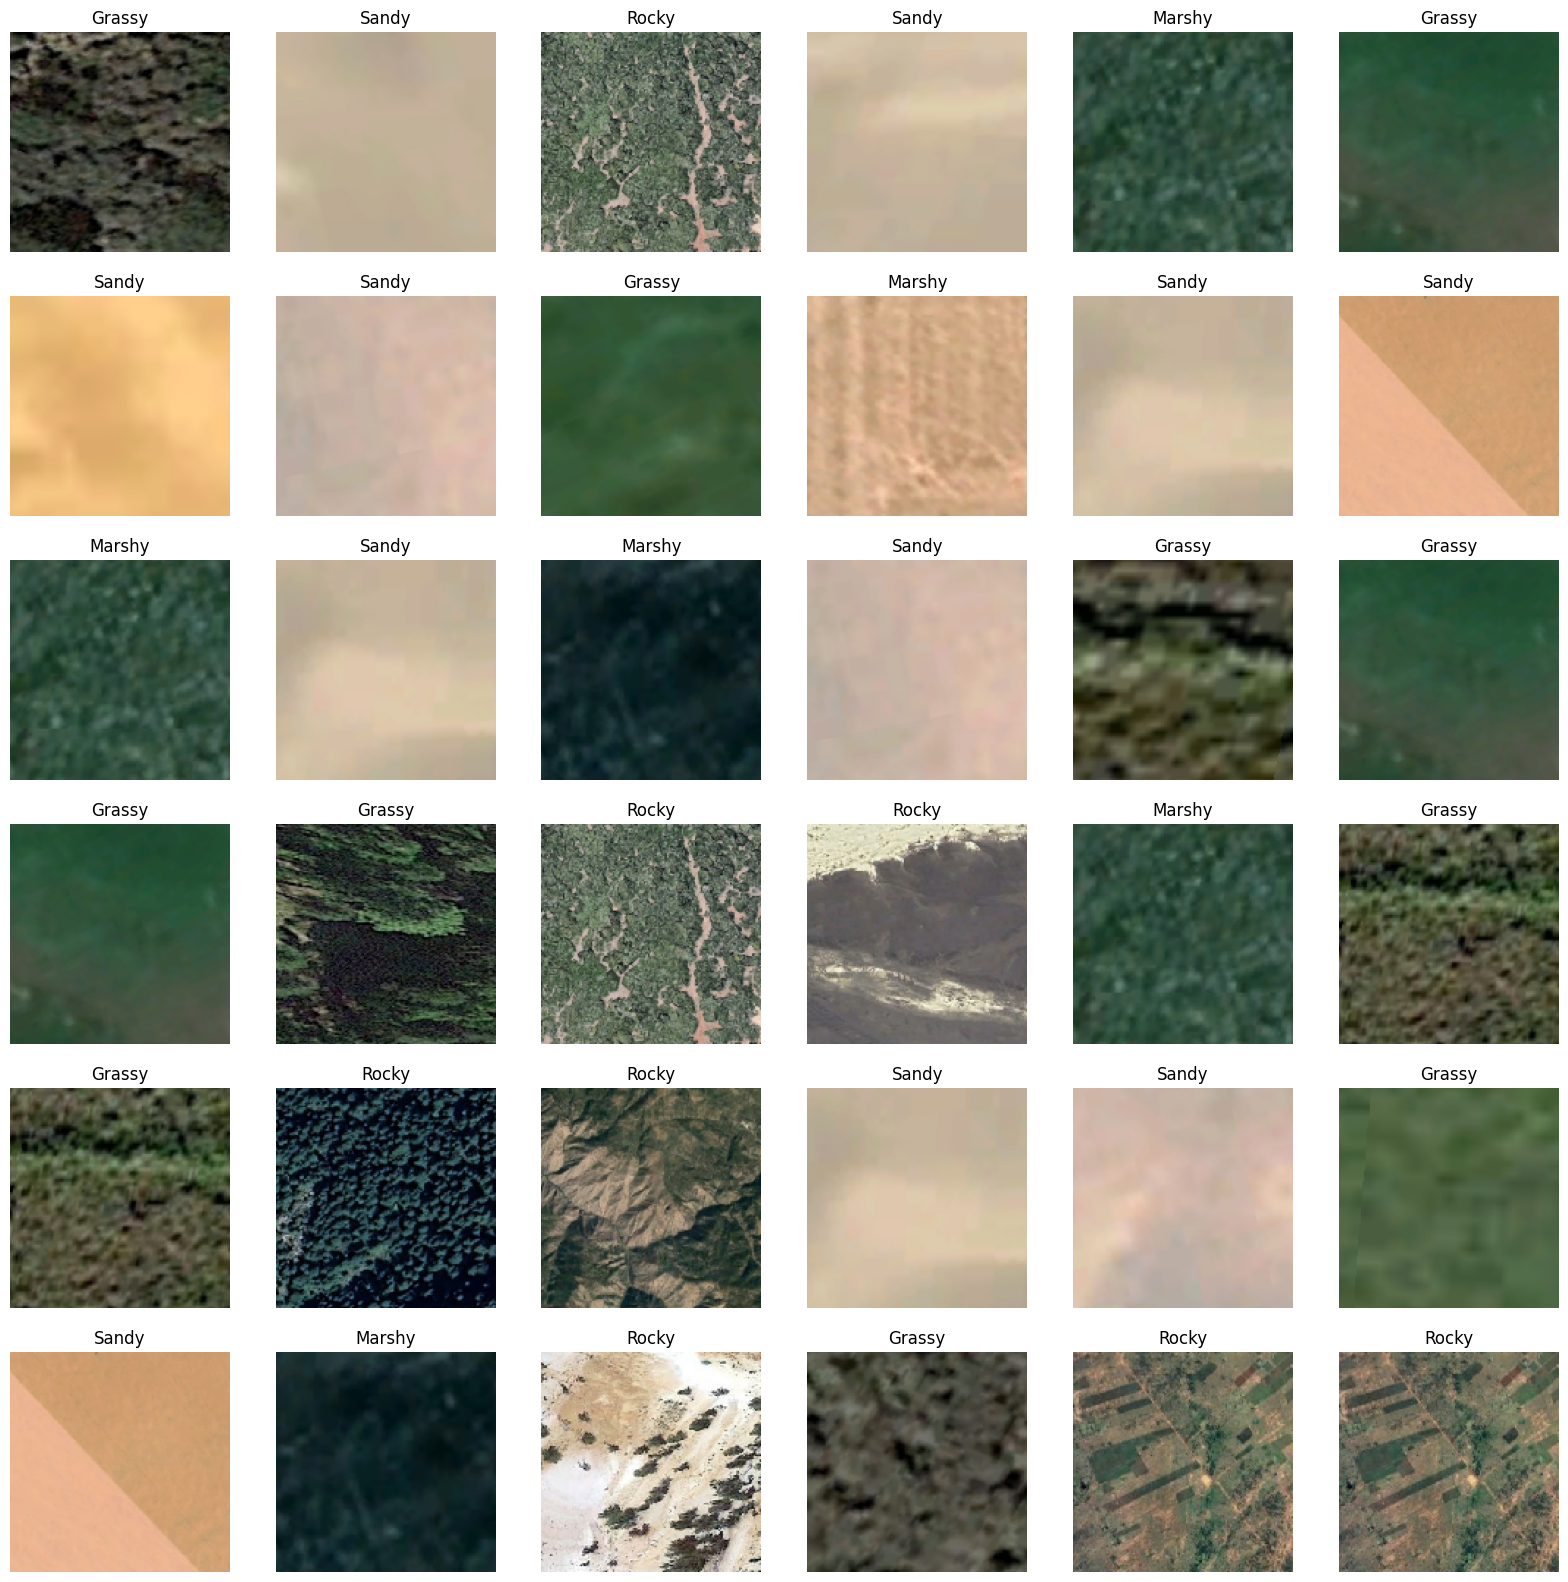

In [ ]:
Show_Images(test_generator)

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
)

In [ ]:
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',
    patience=5,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

In [ ]:
base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras import layers
model = tf.keras.models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6,activation='softmax'),
])

In [ ]:

initial_learning_rate = 0.1
decay_steps = 1000
decay_rate = 0.5
staircase = True
def lr_schedule(epoch, lr):
    if staircase:
        return lr * decay_rate ** (epoch // decay_steps)
    else:
        return lr * decay_rate ** (epoch / decay_steps)

In [ ]:

learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',
    patience=5,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

In [ ]:
from keras.callbacks import LearningRateScheduler
lr_callback = LearningRateScheduler(lr_schedule)
callback=[early_stopping , learning_rate_reduce , lr_callback]

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(lr=lr_callback),
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

In [ ]:
from tensorflow.keras.layers import Dense
model = tf.keras.Sequential(model.layers[:-1])
new_output = Dense(4, activation='softmax')
model.add(new_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[callback]
)

Epoch 1/15
211/211 [==============================] - ETA: 0s - loss: 0.7949 - accuracy: 0.7174

211/211 [==============================] - 802s 4s/step - loss: 0.7949 - accuracy: 0.7174 - val_loss: 0.4260 - val_accuracy: 0.8357 - lr: 0.0010
Epoch 2/15
211/211 [==============================] - ETA: 0s - loss: 0.4701 - accuracy: 0.8222

211/211 [==============================] - 790s 4s/step - loss: 0.4701 - accuracy: 0.8222 - val_loss: 0.3796 - val_accuracy: 0.8465 - lr: 0.0010
Epoch 3/15
211/211 [==============================] - ETA: 0s - loss: 0.3904 - accuracy: 0.8608

211/211 [==============================] - 803s 4s/step - loss: 0.3904 - accuracy: 0.8608 - val_loss: 0.2927 - val_accuracy: 0.8864 - lr: 0.0010
Epoch 4/15
211/211 [==============================] - ETA: 0s - loss: 0.3454 - accuracy: 0.8775

211/211 [==============================] - 723s 3s/step - loss: 0.3454 - accuracy: 0.8775 - val_loss: 0.2602 - val_accuracy: 0.9056 - lr: 0.0010
Epoch 5/15
211/211 [==============================] - ETA: 0s - loss: 0.3035 - accuracy: 0.8970

211/211 [==============================] - 745s 4s/step - loss: 0.3035 - accuracy: 0.8970 - val_loss: 0.2594 - val_accuracy: 0.9030 - lr: 0.0010
Epoch 6/15
211/211 [==============================] - ETA: 0s - loss: 0.2897 - accuracy: 0.8955

211/211 [==============================] - 729s 3s/step - loss: 0.2897 - accuracy: 0.8955 - val_loss: 0.2404 - val_accuracy: 0.9066 - lr: 0.0010
Epoch 7/15
211/211 [==============================] - ETA: 0s - loss: 0.2577 - accuracy: 0.9124

211/211 [==============================] - 725s 3s/step - loss: 0.2577 - accuracy: 0.9124 - val_loss: 0.2577 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 8/15
211/211 [==============================] - ETA: 0s - loss: 0.2298 - accuracy: 0.9221

211/211 [==============================] - 721s 3s/step - loss: 0.2298 - accuracy: 0.9221 - val_loss: 0.2083 - val_accuracy: 0.9266 - lr: 0.0010
Epoch 9/15
211/211 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9152

211/211 [==============================] - 800s 4s/step - loss: 0.2342 - accuracy: 0.9152 - val_loss: 0.2301 - val_accuracy: 0.9180 - lr: 0.0010
Epoch 10/15
211/211 [==============================] - ETA: 0s - loss: 0.2131 - accuracy: 0.9276

211/211 [==============================] - 721s 3s/step - loss: 0.2131 - accuracy: 0.9276 - val_loss: 0.2106 - val_accuracy: 0.9282 - lr: 0.0010
Epoch 11/15
211/211 [==============================] - ETA: 0s - loss: 0.1945 - accuracy: 0.9341

211/211 [==============================] - 748s 4s/step - loss: 0.1945 - accuracy: 0.9341 - val_loss: 0.1926 - val_accuracy: 0.9372 - lr: 0.0010
Epoch 12/15
211/211 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.9397

211/211 [==============================] - 719s 3s/step - loss: 0.1882 - accuracy: 0.9397 - val_loss: 0.2086 - val_accuracy: 0.9297 - lr: 0.0010
Epoch 13/15
211/211 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.9329

211/211 [==============================] - 727s 3s/step - loss: 0.1967 - accuracy: 0.9329 - val_loss: 0.1978 - val_accuracy: 0.9304 - lr: 0.0010
Epoch 14/15
211/211 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.9326

211/211 [==============================] - 722s 3s/step - loss: 0.1949 - accuracy: 0.9326 - val_loss: 0.2396 - val_accuracy: 0.9176 - lr: 0.0010
Epoch 15/15
211/211 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.9442

211/211 [==============================] - 720s 3s/step - loss: 0.1696 - accuracy: 0.9442 - val_loss: 0.2177 - val_accuracy: 0.9384 - lr: 0.0010


In [ ]:
model.save('/kaggle/working/mohan.keras')

In [ ]:
model.save('/usr/mymodel.keras')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


987/987 [==============================] - 614s 620ms/step
Classification Report:
              precision    recall  f1-score   support

      Grassy       0.27      0.27      0.27      8512
      Marshy       0.25      0.24      0.25      7727
       Rocky       0.24      0.25      0.25      7668
       Sandy       0.24      0.24      0.24      7664

    accuracy                           0.25     31571
   macro avg       0.25      0.25      0.25     31571
weighted avg       0.25      0.25      0.25     31571



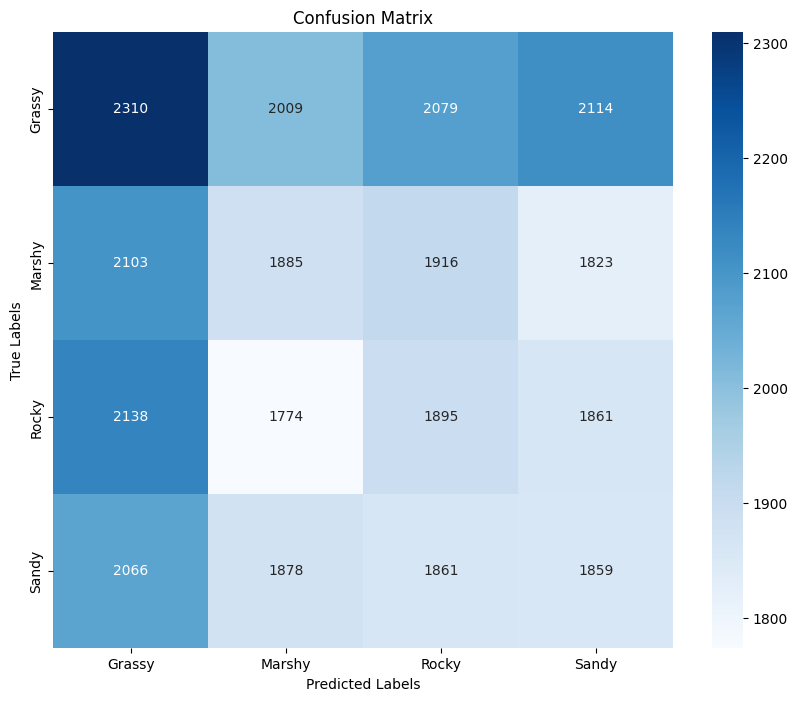

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
loaded_model = load_model('/kaggle/working/mohan.keras')
predictions = loaded_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21770219504833221
Test accuracy: 0.9383611679077148


<Figure size 640x480 with 0 Axes>

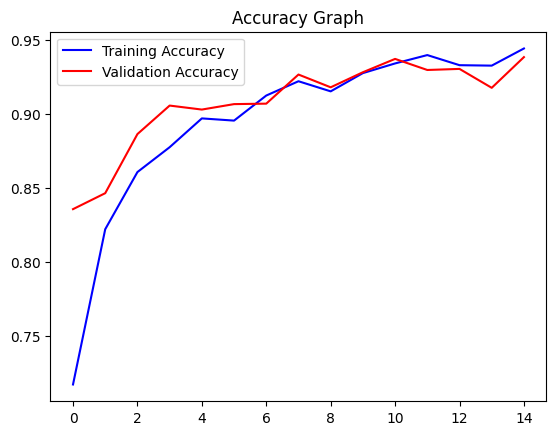

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

In [ ]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 75, 75, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 75, 75, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 75, 75, 32) 

In [ ]:


def predict_terrain(image_path):
  """
  Loads an image, preprocesses it, and predicts the terrain type using the trained model.

  Args:
      image_path: Path to the image file.

  Returns:
      predicted_terrain: The predicted terrain type based on the model's output.
  """

  img = cv2.imread(image_path)
  img = cv2.resize(img, (size_images, size_images))
  img = img.astype('float32') / 255.0
  img = np.expand_dims(img, axis=0)
  prediction = loaded_model.predict(img)
  predicted_class = np.argmax(prediction, axis=1)[0]
  terrain_labels = {0: "Grassy", 1: "Marshy", 2: "Rocky", 3: "Sandy"}
  predicted_terrain = terrain_labels[predicted_class]

  return predicted_terrain

image_path = input("Enter the path to your image: ")

predicted_terrain = predict_terrain(image_path)

print(f"Predicted Terrain: {predicted_terrain}")


KeyboardInterrupt: Interrupted by user